In [8]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
plt.style.use("classic")

# DIP/DOP/PUT Price using the Finite difference methods

In [20]:
def grid_setup(s_min,s_max,T,N,M,sigma,local_vol):
    # Setup of grids
    dt = T/N
    dx = (s_max - s_min)/M
    s = np.linspace(s_min, s_max, M+1)
    t = np.linspace(0, T, N+1)
    t_2 = np.linspace(0, T, M+1)
    #local_vol
    if local_vol == True:
        sigma = (1+t_2/30)*(0.1+0.4*np.exp(-s/50)) #some toy local vol we use to mimick the equity skew
        #should be parametrized in theory according to the market (see Dupire's approach)
    else:
        sigma = sigma
        
    # Set up the vectors A, B and C
    A = 0.5 * sigma**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
    B = - sigma**2 * dt / dx**2 * s**2 - r * dt
    C = 0.5 * sigma**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s
    # Setup the matrix L and I
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)
    return I,L,s, a_diag, b_diag, c_diag, t 

In [15]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [16]:
def VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=False,explicit=True):
    # Grid parameters
    s_min, s_max = 10, 150
    N, M = (s_max-s_min)*10, s_max-s_min
    # Setup of grids
    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Running the explicit scheme

    # Initial condition
    v_ex = np.maximum(K - s, 0) # call option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = K*np.exp(-r*t[n])           # Boundary operation at s_min
        v_ex[M] = 0                           # Boundary operation at s_max

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(K - s, 0)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = K*np.exp(-r*t[n])   # Boundary operator at s_min
        d[M] = 0                   # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
        
    return v_ex[S0-10] if explicit==True else v_im[S0-10]

In [17]:
def EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=True):
    # Grid parameters
    s_min, s_max = Bko, 150
    N, M = abs(s_max-s_min)*10, abs(s_max-s_min)  # N = 1000, M = 100

    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Initial condition
    v_ex = (K-s)*np.int64(K >= s)*np.int64(s >= Bko) # DOP option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at s_min
        v_ex[M] = 0                           # Boundary operation at s_max  

    # Running the implicit scheme

    # Initial condition
    v_im = (K-s)*np.int64(K > s)*np.int64(s > Bko)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s_min
        d[M] = 0  # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
    
    return v_ex[S0-Bko] if explicit==True else v_im[S0-Bko]


In [39]:
def EU_Put_Down_In_Finite_Diff_implicit(S0,Bko,K,r,sigma,T,local_vol=False):
    if local_vol==True:
        return VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=True, 
                explicit=False) - EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=True,explicit=False)
    else:
        return VanillaEU_Put_Finite_Diff(S0,K,r,sigma,T,local_vol=False, 
                explicit=False) - EU_Put_Down_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=False)

In [27]:
S0,K,r,sigma,T=100,100,0.01,0.157,1
#Under Implicit Scheme

DIP_prices_constant_volatility = [EU_Put_Down_In_Finite_Diff_implicit(S0,i,K,r,sigma,T) 
                                           for i in range(60,100,10)]
DOP_prices_constant_volatility = [EU_Put_Down_Out_Finite_Diff(S0,i,K,r,sigma,T,explicit=False) 
                                           for i in range(60,100,10)]
                                  
print("DIP_prices_constant_volatility=",DIP_prices_constant_volatility)
print("DOP_prices_constant_volatility=",DOP_prices_constant_volatility)
print("Vanilla Put Price=",VanillaEU_Put_Finite_Diff(100,K,r,sigma,T,explicit=False))

DIP_prices_constant_volatility= [0.04989699249811963, 0.7130397820488081, 3.106386822981131, 5.429516289455524]
DOP_prices_constant_volatility= [5.687326129303586, 5.024183339752898, 2.630836298820575, 0.30770683234618174]
Vanilla Put Price= 5.737223121801706


# UIC/UOC/Call Price using the Finite difference methods

In [54]:
def VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=True,explicit=True):
    # Grid parameters
    s_min, s_max = 1, 150
    N, M = (s_max-s_min)*10, s_max-s_min
    # Setup of grids
    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Running the explicit scheme

    # Initial condition
    v_ex = np.maximum(s - K, 0) # call option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at s_min
        v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

    # Running the implicit scheme

    # Initial condition
    v_im = np.maximum(s - K, 0)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s_min
        d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
        
    return v_ex[S0-1] if explicit==True else v_im[S0-1]

In [74]:
def EU_Call_Up_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=True):
    # Grid parameters
    s_min, s_max = 1, Bko
    N, M = (Bko-s_min)*10, Bko-s_min  # N = 1000, M = 100

    I,L, s, a_diag, b_diag, c_diag, t = grid_setup(s_min,s_max,T,N,M,sigma,local_vol)
    # Initial condition
    v_ex = (s-K)*np.int64(K < s)*np.int64(s < Bko) # UOC option payoff

    # Iteration of explicit scheme
    for n in range(1,N+1):
        v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at s_min
        v_ex[M] = 0                           # Boundary operation at s_max  

    # Running the implicit scheme

    # Initial condition
    v_im = (s-K)*np.int64(K < s)*np.int64(s < Bko)

    # Iteration of implicit scheme
    for n in range(1,N+1):

        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = 0   # Boundary operator at s_min
        d[M] = 0  # Boundary operator at s_min
        v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n
    
    return v_ex[S0-1] if explicit==True else v_im[S0-1]


In [57]:
def EU_Call_Up_In_Finite_Diff_implicit(S0,Bko,K,r,sigma,T,local_vol=False):
    if local_vol==True:
        return VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=True, 
                explicit=False) - EU_Call_Up_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=True,explicit=False)
    else:
        return VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=False, 
                explicit=False) - EU_Call_Up_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=False)

In [58]:
def EU_Call_Up_In_Finite_Diff_explicit(S0,Bko,K,r,sigma,T,local_vol=False):
    if local_vol==True:
        return VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=True, 
                explicit=True) - EU_Call_Up_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=True,explicit=True)
    else:
        return VanillaEU_Call_Finite_Diff(S0,K,r,sigma,T,local_vol=False, 
                explicit=True) - EU_Call_Up_Out_Finite_Diff(S0,Bko,K,r,sigma,T,local_vol=False,explicit=True)

In [61]:
S0,K,r,sigma,T=100,100,0.01,0.157,1
#Under Implicit Scheme
UOC_prices_constant_volatility_implicit = [EU_Call_Up_Out_Finite_Diff(S0,i,K,r,sigma,T) for i in range(100,150,10)]
UIC_prices_constant_volatility_implicit = [EU_Call_Up_In_Finite_Diff_explicit(S0,i,K,r,sigma,T) for i in range(100,150,10)]
print(UOC_prices_constant_volatility_implicit)
print(UIC_prices_constant_volatility_implicit)
print("Vanilla Call Price=",VanillaEU_Call_Finite_Diff(100,K,r,sigma,T,explicit=False))

[0.0, 0.224918757955326, 1.7799999316946649, 3.9497781984375435, 5.49052264848901]
[6.733338808950464, 6.508420050995138, 4.953338877255799, 2.7835606105129203, 1.2428161604614534]
Vanilla Call Price= 6.759786710225255


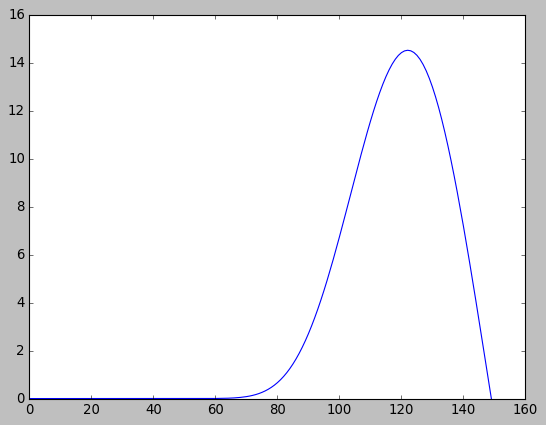

In [79]:
CUO_price=[EU_Call_Up_Out_Finite_Diff(i,150,K,r,sigma,T) for i in range(1,151,1)]
plt.plot(CUO_price)

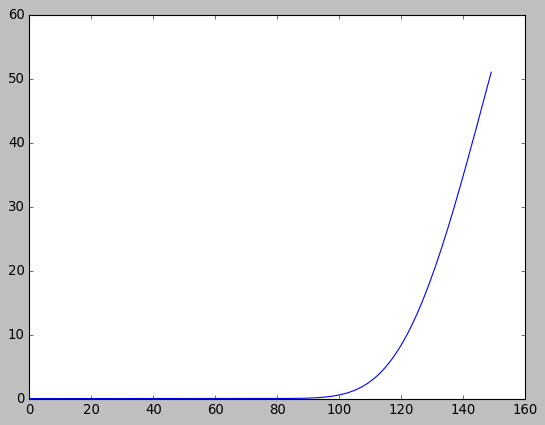

In [80]:
CUI_price=[EU_Call_Up_In_Finite_Diff_implicit(i,150,K,r,sigma,T) for i in range(1,151,1)]
plt.plot(CUI_price)

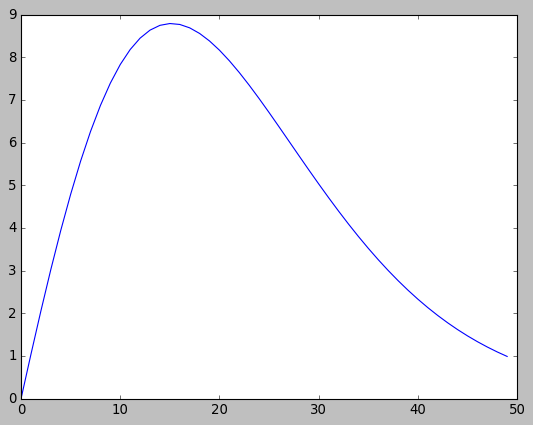

In [96]:
DOP_price=[EU_Put_Down_Out_Finite_Diff(i,70,K,r,sigma,T) for i in range(70,120,1)]
plt.plot(DOP_price)

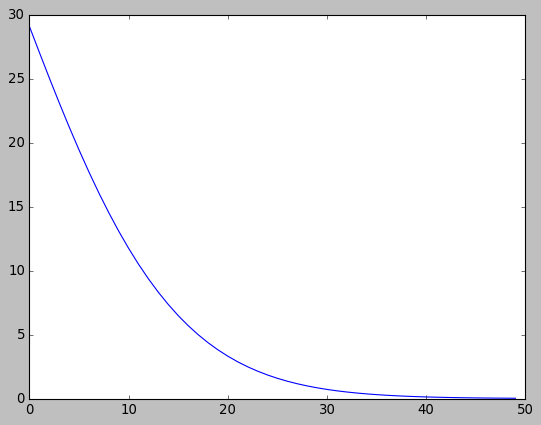

In [95]:
DIP_price=[EU_Put_Down_In_Finite_Diff_implicit(i,70,K,r,sigma,T) for i in range(70,120,1)]
plt.plot(DIP_price)